In [1]:
import sympy as sym
import numpy as np
from scipy import signal
from scipy import linalg
import matplotlib.pyplot as plt
sym.init_printing()

In [2]:
grav = 9.8

In [3]:
# Define mass and moment of inertia of the bus
mass = 0.5    # in kilograms
Ixx = 0.0023  # in kilograms
Iyy = 0.0023  # in kilograms
Izz = 0.0040  # in kilograms
lxy = 0.25    # x/y distance from the quadrotor frame to the mocap markers (m)
lz = 0.046875 # z distance from the quadrotor frame to the mocap markers (m)

px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

phi, theta, psi = sym.symbols('phi, theta, psi')

wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

# Define inputs
taux_inB, tauy_inB, tauz_inB, fz_inB = sym.symbols('tau_x, tau_y, tau_z, f_z')

# Get the net torque vector
tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

# Get the gravity force and convert to body coordiantes
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Get the net force vector
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)

I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)

v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)

ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

M_inv = sym.simplify(M.inv())

rpy_dot = sym.simplify(M_inv@w_inB)

w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)

In [4]:
f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

In [5]:
m = [px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB]
n = [taux_inB, tauy_inB, tauz_inB, fz_inB]

px_inW_e, py_inW_e, pz_inW_e = 0.0, 0.0, 0.0
vx_inB_e, vy_inB_e, vz_inB_e = 0.0, 0.0, 0.0
phi_e, theta_e, psi_e = 0.0, 0.0, 0.0
wx_inB_e, wy_inB_e, wz_inB_e = 0.0, 0.0, 0.0

taux_inB_e, tauy_inB_e, tauz_inB_e, fz_inB_e = 0.0, 0.0, 0.0, 9.81/2

A_num = sym.lambdify((px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB), f.jacobian(m))
A = A_num(px_inW_e, py_inW_e, pz_inW_e, vx_inB_e, vy_inB_e, vz_inB_e, phi_e, theta_e, psi_e, wx_inB_e, wy_inB_e, wz_inB_e, taux_inB_e, tauy_inB_e, tauz_inB_e, fz_inB_e)

B_num = sym.lambdify((px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB), f.jacobian(n))
B = B_num(px_inW_e, py_inW_e, pz_inW_e, vx_inB_e, vy_inB_e, vz_inB_e, phi_e, theta_e, psi_e, wx_inB_e, wy_inB_e, wz_inB_e, taux_inB_e, tauy_inB_e, tauz_inB_e, fz_inB_e)

In [6]:
# Checking for controllability

def controllability(A, B):
    Wc = B
    for i in range(1, A.shape[0]):
        col = np.linalg.matrix_power(A, i) @ B
        Wc = np.block([Wc, col])

    rank_Wc = np.linalg.matrix_rank(Wc)
    return np.allclose(rank_Wc, A.shape[0])

print("Controllability:", controllability(A, B))

Controllability: True


In [32]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K, P

# uses Bryson's Rule
Qc= np.diag([1/100**2, 1/100**2, 1/10**2, 1/100**2, 1/100**2, 1/100**2, 1/50**2, 1/100**2, 1/100**2, 1/40**2, 1/40**2, 1/40**2])
Rc = np.diag([1/0.35**2, 1/0.35**2, 1/0.35**2, 1/18**2])

# get gain matrix K
K, P = lqr(A, B, Qc, Rc)


# Test system stability
def stability(K):
    F = A - B@K
    return (linalg.eigvals(F).real < 0).all()

print("Stability:", stability(K))

Stability: True


In [56]:
def ec_path(dt=0.01):
    path = []

    # Speeds and durations
    ascent_speed = 0.1       # 1 m/s
    horizontal_speed = 1.0   # 1 m/s
    descend_speed = 0.01     # 1 cm/s (0.01 m/s)

    # Times for each phase
    ascent_time = 10    # 1 second to ascend 1 meter at 1 m/s
    move_time = 5.0      # 5 seconds to move 5 meters at 1 m/s
    hover_time = 3.0      # 1 second hover
    descend_time = 110.0  # 100 seconds to descend 1 meter at 0.01 m/s

    # Convert times to steps
    ascent_steps = int(ascent_time / dt)       # 1 s / 0.01 s = 100 steps
    move_steps = int(move_time / dt)           # 5 s / 0.01 s = 500 steps
    hover_steps = int(hover_time / dt)         # 1 s / 0.01 s = 100 steps
    descend_steps = int(descend_time / dt)     # 100 s / 0.01 s = 10000 steps

    # Ascent (1 m total)
    for i in range(ascent_steps):
        z = i * dt * ascent_speed   # z goes from 0 to 1 m
        path.append([0, 0, z])

    # Move along x-axis (5 m total)
    for i in range(move_steps):
        x = i * dt * horizontal_speed  # x from 0 to 5 m
        path.append([x, 0, 1])

    # Hover at (5,0,1)
    for _ in range(hover_steps):
        path.append([5, 0, 1])

    # Move along y-axis (5 m total)
    for i in range(move_steps):
        y = i * dt * horizontal_speed  # y from 0 to 5 m
        path.append([5, y, 1])

    # Hover at (5,5,1)
    for _ in range(hover_steps):
        path.append([5, 5, 1])

    # Descend at 1 cm/s (0.01 m/s) from 1 m over 100 s
    for i in range(descend_steps):
        z = 1 - i * dt * descend_speed  # from 1 m down to 0 m
        path.append([5, 5, z])

    return np.array(path)


In [57]:
# Create the Controller class
class Controller():
    def __init__(self, goal_path):

        # define matrices for state space form with output
        self.A = A
        self.B = B
        # define gain matrices
        self.K = K
        # define desired equilibrium position
        self.px_inW_e = px_inW_e
        self.py_inW_e = py_inW_e
        self.pz_inW_e = pz_inW_e
        self.vx_inB_e = vx_inB_e
        self.vy_inB_e = vy_inB_e
        self.vz_inB_e = vz_inB_e
        self.phi_e = phi_e
        self.theta_e = theta_e
        self.psi_e = psi_e
        self.wx_inB_e = wx_inB_e
        self.wy_inB_e = wy_inB_e
        self.wz_inB_e = wz_inB_e

        self.taux_inB_e = taux_inB_e
        self.tauy_inB_e = tauy_inB_e
        self.tauz_inB_e = tauz_inB_e
        self.fz_inB_e = fz_inB_e

        self.goal_path = goal_path
        self.current_point = 0
        self.num_points = len(goal_path)

        # Create variable to keeps track of all previous xhat data
        self.xhat_history = {"px" : [],
                            "py" : [],
                            "pz" : [],
                            "vx" : [],
                            "vy" : [],
                            "vz" : [],
                            "phi" : [],
                            "theta": [],
                            "psi" : [],
                            "wx" : [],
                            "wy" : [],
                            "wz" : []}


    def reset(self):

        self.xhat = np.zeros(12)
        self.current_point = 0

        # Reset the variable keeping track of xhat data
        self.xhat_history = {"px" : [],
                            "py" : [],
                            "pz" : [],
                            "vx" : [],
                            "vy" : [],
                            "vz" : [],
                            "phi" : [],
                            "theta": [],
                            "psi" : [],
                            "wx" : [],
                            "wy" : [],
                            "wz" : []}


    def run(self, **kwargs):


        # if finished performance goal, stop
        if self.current_point >= self.num_points:
            return [0, 0, 0, 0]

        self.dt = kwargs["dt"]
        self.p_hat = self.xhat[:3]
        self.p_goal = self.goal_path[self.current_point]

        self.x_des = np.hstack((self.p_goal, np.zeros(9)))

        u = -self.K @ (self.xhat - self.x_des)
        inputs = u + np.array([self.taux_inB_e, self.tauy_inB_e, self.tauz_inB_e, self.fz_inB_e])

        p_error = np.linalg.norm(self.xhat[:3] - self.x_des[:3])
        if p_error <= 1.1:
            self.current_point += 1


        self.xhat += self.dt * (self.A@self.xhat + self.B@u)

        # Store the current xhat
        self.xhat_history["px"].append(self.xhat[0])
        self.xhat_history["py"].append(self.xhat[1])
        self.xhat_history["pz"].append(self.xhat[2])
        self.xhat_history["vx"].append(self.xhat[3])
        self.xhat_history["vy"].append(self.xhat[4])
        self.xhat_history["vz"].append(self.xhat[5])
        self.xhat_history["phi"].append(self.xhat[6])
        self.xhat_history["theta"].append(self.xhat[7])
        self.xhat_history["psi"].append(self.xhat[8])
        self.xhat_history["wx"].append(self.xhat[9])
        self.xhat_history["wy"].append(self.xhat[10])
        self.xhat_history["wz"].append(self.xhat[11])

        return inputs

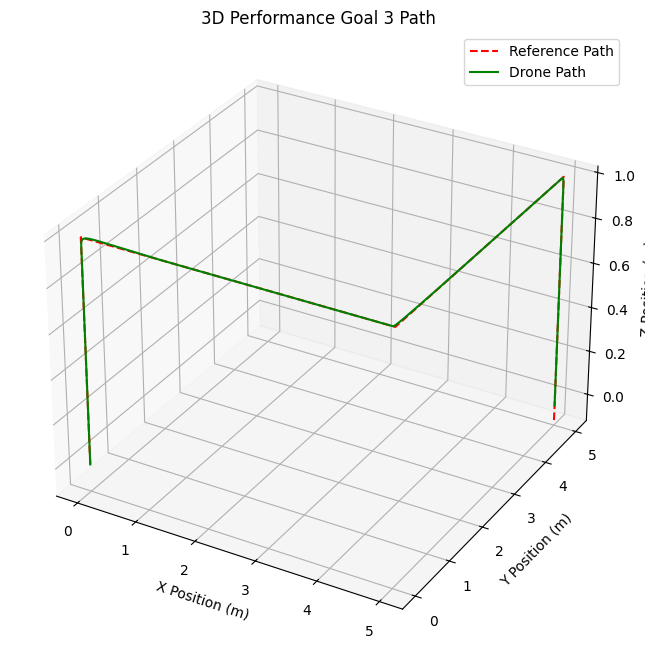

In [58]:
straight_yaw_path = ec_path()

# controller reset
straight_yaw_controller = Controller(goal_path=straight_yaw_path)
straight_yaw_controller.reset()
straight_yaw_controller.xhat[:3] = straight_yaw_path[0]  # Start at the first waypoint


time_steps = np.arange(0, len(straight_yaw_path)*0.01 , 0.01)
for t in time_steps:
    straight_yaw_controller.run(dt=0.01, time=t)

actual_x = straight_yaw_controller.xhat_history["px"]
actual_y = straight_yaw_controller.xhat_history["py"]
actual_z = straight_yaw_controller.xhat_history["pz"]


ref_x = [point[0] for point in straight_yaw_path]
ref_y = [point[1] for point in straight_yaw_path]
ref_z = [point[2] for point in straight_yaw_path]


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(ref_x, ref_y, ref_z, 'r--', label="Reference Path")  # Reference path
ax.plot(actual_x, actual_y, actual_z, 'g', label="Drone Path")  # Actual path
ax.set_title("3D Performance Goal 3 Path")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_zlabel("Z Position (m)")
ax.legend()
plt.show()


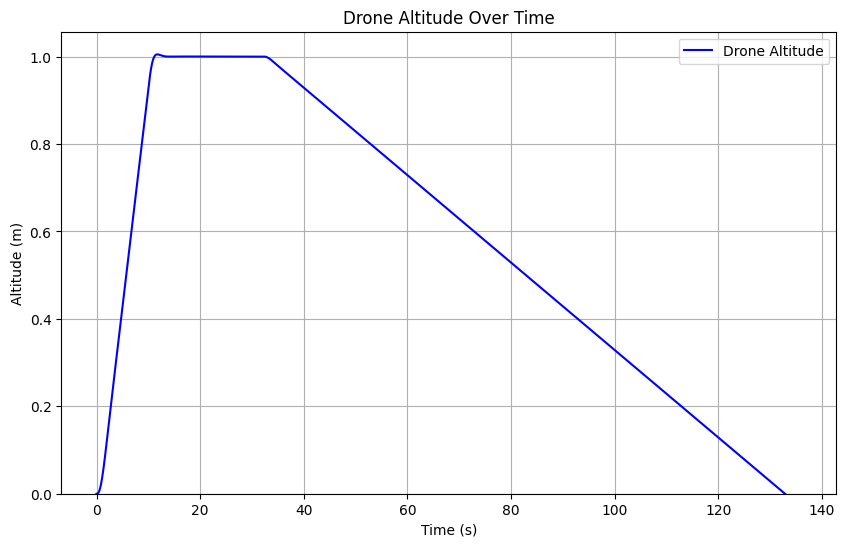

In [59]:
# Extract altitude (z-position) over time
time_steps = np.arange(0, len(actual_z) * 0.01, 0.01)  # Time vector
altitude = actual_z  # Altitude values

# Plot altitude over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, altitude, color="blue", label="Drone Altitude")
plt.title("Drone Altitude Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.grid()
plt.ylim(bottom=0)
plt.legend()
plt.show()